In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, dual_annealing, basinhopping
import os 

from scipy.fft import ifft, fft, rfft, irfft

In [2]:
if not os.path.exists('figures_noisy'):
    os.mkdir('figures_noisy')

In [3]:
def shift(arr, num):
    result = np.empty_like(arr)
    fill_value = np.mean(arr[-5:])
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [4]:
SEIR_outputs =   pd.read_csv('noisy_seir_results.csv')
true_incidence =  SEIR_outputs['scaled_incidence'].to_numpy()
symptomatic_incidence =  SEIR_outputs['symptomatic_incidence'].to_numpy()


In [5]:
def smooth_signal(y, thresh=100):
    signal = rfft(y)
    signal[thresh:] = 0
    resignal = irfft(signal)
    return resignal


True


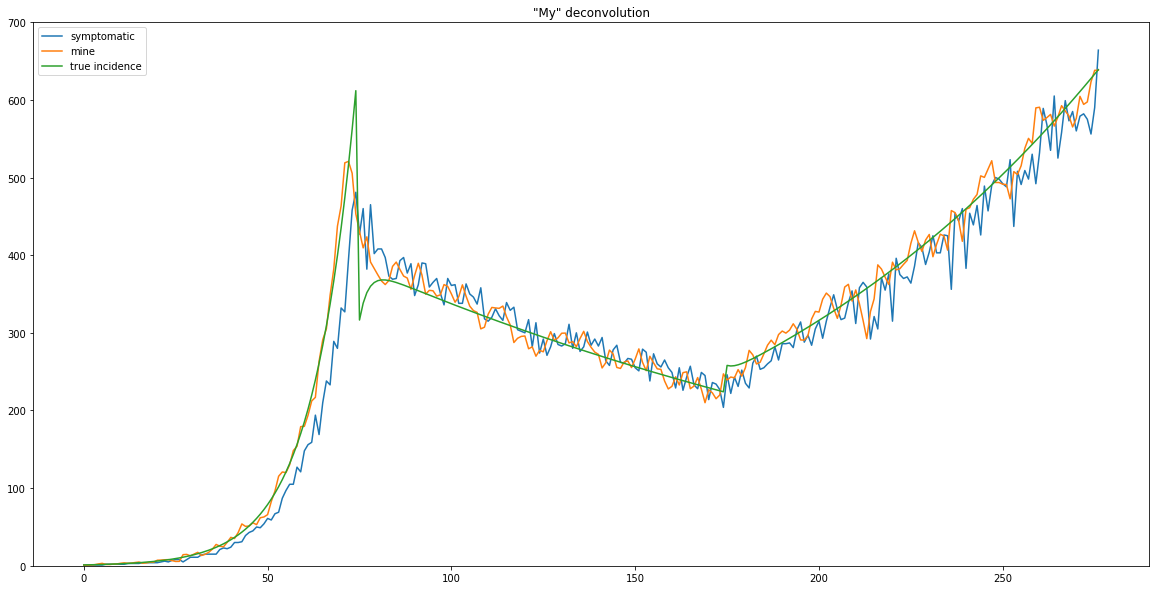

In [32]:
true_kernel = pd.read_csv('serial_interval.csv')['si']#'incubation_interval.csv')['pdf']
mean_shift = np.sum((np.arange(len(true_kernel)))* true_kernel)
starting_shift = int(np.round(mean_shift))


def optimizer_function(real_incidence):
    L = len(true_kernel) - 1
    convolved = np.convolve(real_incidence, true_kernel, mode='valid')
    scaling = np.max(symptomatic_incidence[L:])

    scaled_convolved = convolved *1000000 #/np.max(symptomatic_incidence[L:]) *1000000
    scaled_incidence = symptomatic_incidence[L:] *1000000 #/np.max(symptomatic_incidence[L:]) *1000000

    penalty = 1E8 * np.mean(np.abs(np.diff(real_incidence)/scaling)**2)

    loglikelihoods = scaled_incidence*np.log(scaled_convolved) - scaled_convolved

    return -np.mean(loglikelihoods)+penalty
#weiner_deconvolved = wiener_deconvolution(symptomatic_incidence, true_kernel, 0.2)


x0 = shift(symptomatic_incidence, -1*starting_shift)#symptomatic_incidence 
xs = minimize(optimizer_function, x0, bounds = [(0, np.inf) for _ in x0],options={'maxiter':100000}, method='Powell')

print(xs.success)

plt.figure(figsize=(20, 10))
L = (len(true_kernel)-1)
plt.plot(symptomatic_incidence[L:], label='symptomatic')

plt.plot(xs.x[L:], label='mine')
plt.plot(true_incidence[L:], label='true incidence')

plt.title('"My" deconvolution')

plt.legend()
plt.ylim(0, 700)
plt.savefig('figures_noisy/my_deconv.png')
plt.show()

# The problem with Wiener deconvolution is that higher penalty not only smooths, but lowers it...
#plt.figure(figsize=(20, 10))
#plt.plot(weiner_deconvolved[L:], label='weiner deconv.')
#plt.plot(true_incidence[L:], label='true incidence')
#plt.title('Wiener deconvolution')
#plt.plot(symptomatic_incidence[L:], label='symptomatic')

#plt.legend()
#plt.ylim(0, 700)
#plt.savefig('figures_noisy/wiener_deconv.png')

#plt.show()
